In [2]:
import os
import sys
sys.path.append('..')
import numpy as np
import os
import matplotlib.pyplot as plt

import analysis


from importlib import reload

In [3]:
reload(analysis)

data_dir = "/SNS/NOM/IPTS-34537/shared/sliced/reduced/GSAS"

temps, ramp = analysis.load_data(data_dir)


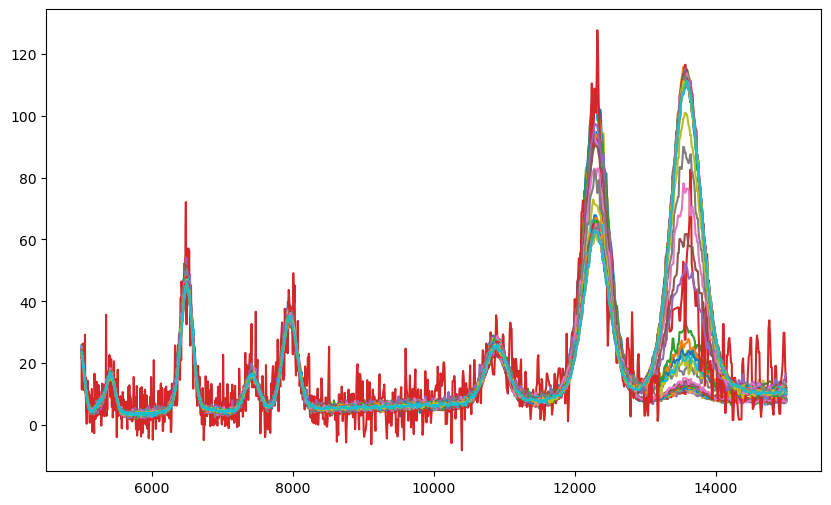

In [6]:
plt.figure(figsize=(10, 6))

for i, r in enumerate(ramp[25:75]):
    idx = [(v >= 5000) & (v <= 17500) for v in r[0]]
    plt.plot(r[0][idx], r[1][idx], label=f'Run {i}')

#plt.legend()

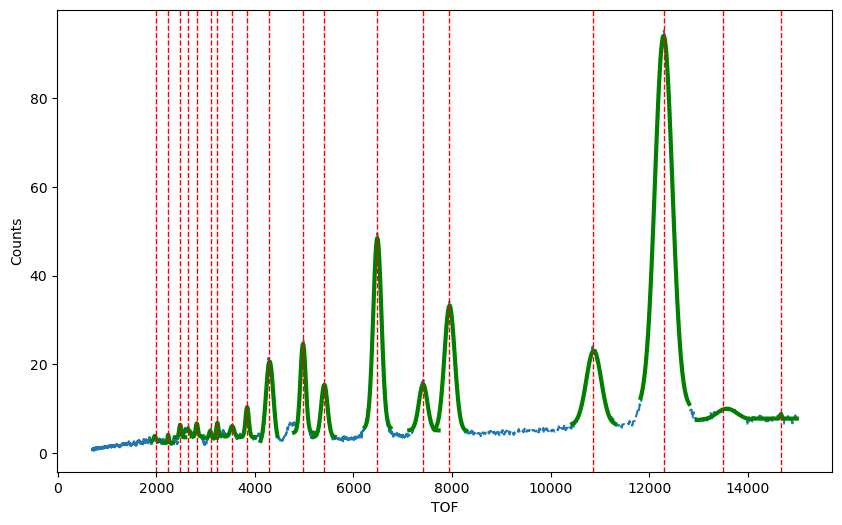

In [ ]:
reload(analysis)

index = 1

tof = ramp[index][0]
counts = ramp[index][1]

peak = analysis.peak_finder(tof, counts, peak_prominence=2)